# Ethereum Return Forecasting during COVID-19

## I. Introduction

### **Context**
The COVID-19 pandemic has had far-reaching effects beyond public health, significantly influencing global financial markets — including the cryptocurrency sector. Ethereum (ETH), as one of the largest cryptocurrencies by market capitalization, experienced periods of extreme volatility during the pandemic.  
Pandemic-related indicators such as vaccination rates, hospitalization counts, and test positivity rates may have contributed to investor sentiment and influenced ETH price movements.

### **Problem Statement**
- **Investor Perspective:** Traders and investors in cryptocurrency markets face heightened uncertainty during global crises. Identifying relevant macro-health indicators can help them make more informed decisions.  
- **Analytical Perspective:** By combining pandemic-related data with market statistics, we can assess whether such external health factors improve ETH return forecasting accuracy.

### **Stakeholders**
- **Crypto Traders & Investors:** Adjust positions based on predictions influenced by macro-health data.  
- **Financial Analysts & Researchers:** Explore causal and predictive relationships between health events and crypto market returns.  
- **Portfolio Managers:** Integrate macro-health indicators into portfolio optimization and risk models.  
- **Data Scientists:** Build robust models that incorporate non-financial predictors into market forecasting.

### **Goals**
1. Predict daily ETH returns using LightGBM.  
2. Apply **Genetic Algorithm (GA)** for feature selection to identify the most relevant predictors.  
3. Optimize model hyperparameters via GA to maximize prediction performance.  
4. Evaluate predictions using **financial metrics** (Sharpe Ratio, Maximum Drawdown, Total Return, Directional Accuracy) and **statistical metrics** (RMSE, MAE, MAPE, MSE).

### **Business Impact**
Incorporating pandemic indicators into ETH forecasting can improve risk management, provide early warning signals, and enhance understanding of how macro-health events affect cryptocurrency markets.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## II. Data Understanding & Preparations

### Data Sources
1. **Ethereum Historical Price Data** – Downloaded from Yahoo Finance (`ETH-USD`) covering the period **December 2020 – June 2022**.  
   - **Variables:** Open, High, Low, Close, Volume, and calculated log returns.  
2. **COVID-19 Pandemic Data** – Sourced from Our World in Data (OWID), filtered for global indicators relevant to the study.  
   - **Variables:** Vaccination rates, ICU patients, hospitalization counts, positive test rate, testing volume.

In [3]:
# Get ETH-USD historical data from Yahoo Finance
eth = yf.download('ETH-USD', start='2020-12-01', end='2022-06-30')
eth = eth[['Close']].rename(columns={'Close': 'eth_close'})
eth['eth_return'] = np.log(eth['eth_close'] / eth['eth_close'].shift(1))
eth = eth.dropna()
eth.head()

C:\Users\giova\AppData\Local\Temp\ipykernel_1184\2905554587.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download('ETH-USD', start='2020-12-01', end='2022-06-30')
[*********************100%***********************]  1 of 1 completed


Price,eth_close,eth_return
Ticker,ETH-USD,
Date,,
2020-12-02,598.352356,0.018603
2020-12-03,616.708740,0.030217
2020-12-04,569.354187,-0.079894
2020-12-05,596.595459,0.046737
2020-12-06,601.908997,0.008867


In [4]:
# Load COVID data from Our World in Data
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN


### Data Preparations

In [5]:
covid = covid[covid["location"] == "World"]
covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
422729,OWID_WRL,NaN,World,2020-01-05,2.0,2.0,NaN,3.0,3.0,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
422730,OWID_WRL,NaN,World,2020-01-06,2.0,0.0,NaN,3.0,0.0,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
422731,OWID_WRL,NaN,World,2020-01-07,2.0,0.0,NaN,3.0,0.0,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
422732,OWID_WRL,NaN,World,2020-01-08,2.0,0.0,NaN,3.0,0.0,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
422733,OWID_WRL,NaN,World,2020-01-09,2.0,0.0,NaN,3.0,0.0,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN


In [6]:
# Convert 'date' column to datetime format
covid["date"] = pd.to_datetime(covid["date"])

# Set 'date' as the DataFrame index
covid.set_index("date", inplace=True)

# Rename 'date' column to 'Date' (if it still exists in the DataFrame)
covid = covid.rename(columns={"date": "Date"})


In [7]:
covid.tail()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2024-08-10,OWID_WRL,NaN,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
2024-08-11,OWID_WRL,NaN,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
2024-08-12,OWID_WRL,NaN,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
2024-08-13,OWID_WRL,NaN,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN
2024-08-14,OWID_WRL,NaN,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.64,60.13,2.7,72.58,0.74,7975105024,NaN,NaN,NaN,NaN


In [8]:
# Select the relevant COVID-19 features based on the paper's methodology
# These features are related to vaccination progress and trends, which may influence ETH returns
selected_cols = [
    "people_fully_vaccinated_per_hundred",         # % of population fully vaccinated
    "people_vaccinated_per_hundred",               # % of population with at least one dose
    "total_boosters_per_hundred",                  # % of population that received booster shots
    "new_people_vaccinated_smoothed",              # Smoothed daily number of newly vaccinated people
    "new_vaccinations_smoothed_per_million",       # Smoothed daily vaccinations per million people
    "new_people_vaccinated_smoothed_per_hundred"   # Smoothed daily newly vaccinated as % of population
]


In [9]:
# Select only the COVID-19 features we want to use for modeling
covid = covid[selected_cols]

# Take a quick look at the first few rows to make sure the selection is correct
covid.head()


,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred,total_boosters_per_hundred,new_people_vaccinated_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred
date,,,,,,
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Smooth the COVID-19 data using a 14-day rolling average 
# to highlight longer-term trends and reduce daily volatility
covid = covid.rolling(window=14).mean()

# Display the first few rows of the smoothed data
covid.head()

,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred,total_boosters_per_hundred,new_people_vaccinated_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred
date,,,,,,
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2020-01-05 to 2024-08-14
Data columns (total 6 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   people_fully_vaccinated_per_hundred         1328 non-null   float64
 1   people_vaccinated_per_hundred               1339 non-null   float64
 2   total_boosters_per_hundred                  1312 non-null   float64
 3   new_people_vaccinated_smoothed              1333 non-null   float64
 4   new_vaccinations_smoothed_per_million       1333 non-null   float64
 5   new_people_vaccinated_smoothed_per_hundred  1333 non-null   float64
dtypes: float64(6)
memory usage: 92.1 KB


In [12]:
# Convert indexes to datetime for both datasets
eth.index = pd.to_datetime(eth.index)
covid.index = pd.to_datetime(covid.index)

In [13]:
eth.head()

Price,eth_close,eth_return
Ticker,ETH-USD,
Date,,
2020-12-02,598.352356,0.018603
2020-12-03,616.708740,0.030217
2020-12-04,569.354187,-0.079894
2020-12-05,596.595459,0.046737
2020-12-06,601.908997,0.008867


In [14]:
# Flatten multi-level columns to a single level
eth.columns = eth.columns.get_level_values(0)

# Ensure index is in datetime format
eth.index = pd.to_datetime(eth.index)

**Merging**  
   - Merged ETH return data with COVID-19 features on the date index.

In [17]:
data = eth[['eth_return']].merge(covid, left_index=True, right_index=True)
data.tail()

,eth_return,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred,total_boosters_per_hundred,new_people_vaccinated_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred
2022-06-25,0.013442,59.682143,65.351429,26.028571,1.802035e+06,1049.642857,0.021429
2022-06-26,-0.035706,59.715714,65.374286,26.075000,1.841840e+06,1059.571429,0.022143
2022-06-27,-0.005140,59.750714,65.397857,26.124286,1.881411e+06,1071.500000,0.022857
2022-06-28,-0.042004,59.785714,65.421429,26.171429,1.932172e+06,1088.500000,0.023571
2022-06-29,-0.040687,59.821429,65.447143,26.219286,1.994237e+06,1105.785714,0.024286


**Feature Engineering**  
   - Created lagged ETH returns (`lag_return`).  
   - Encoded `day_of_week` both as integer and cyclical features (`dow_cos`).

In [18]:
data['lag_return'] = data['eth_return'].shift(1)
data['day_of_week'] = data.index.dayofweek
data['dow_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
data['target_return'] = data['eth_return'].shift(-7)

**Data Cleaning**  
   - Removed missing values and aligned date ranges between ETH price data and COVID-19 data.  
   - Aggregated and smoothed COVID-19 indicators using a **14-day rolling mean** to reduce noise.

In [19]:
data = data.dropna()
data.head()

,eth_return,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred,total_boosters_per_hundred,new_people_vaccinated_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,lag_return,day_of_week,dow_cos,target_return
2021-01-11,-0.146582,0.005714,0.147857,0.0,8.672564e+05,166.714286,0.010714,-0.014808,0,1.000000,0.021796
2021-01-12,-0.043793,0.007857,0.163571,0.0,9.288547e+05,178.928571,0.011429,-0.146582,1,0.623490,0.091172
2021-01-13,0.080354,0.010714,0.180000,0.0,9.921325e+05,191.357143,0.012143,-0.043793,2,-0.222521,0.003608
2021-01-14,0.074710,0.013571,0.197857,0.0,1.060651e+06,207.285714,0.012857,0.080354,3,-0.900969,-0.209000
2021-01-15,-0.039011,0.016429,0.217857,0.0,1.134914e+06,223.928571,0.013571,0.074710,4,-0.900969,0.097564


In [20]:
# Define COVID-related columns for rolling statistics
covid_cols = [
    "people_fully_vaccinated_per_hundred",
    "people_vaccinated_per_hundred",
    "total_boosters_per_hundred",
    "new_people_vaccinated_smoothed",
    "new_vaccinations_smoothed_per_million",
    "new_people_vaccinated_smoothed_per_hundred"
]

# Rolling window size
window = 14

# Create rolling statistics features
stat_features = {}
for col in covid_cols:
    roll = data[col].rolling(window)
    stat_features[f"{col}_mean"] = roll.mean()
    stat_features[f"{col}_median"] = roll.median()
    stat_features[f"{col}_p75"] = roll.quantile(0.75)
    stat_features[f"{col}_range"] = roll.max() - roll.min()
    stat_features[f"{col}_diff"] = data[col].diff()

# Combine into a DataFrame
stat_df = pd.DataFrame(stat_features, index=data.index)

# Merge with ETH return data and remove NaN rows
data_full = pd.concat([data[["eth_return"]], stat_df], axis=1).dropna()


,eth_return,people_fully_vaccinated_per_hundred_mean,people_fully_vaccinated_per_hundred_median,people_fully_vaccinated_per_hundred_p75,people_fully_vaccinated_per_hundred_range,people_fully_vaccinated_per_hundred_diff,people_vaccinated_per_hundred_mean,people_vaccinated_per_hundred_median,people_vaccinated_per_hundred_p75,people_vaccinated_per_hundred_range,...,new_vaccinations_smoothed_per_million_mean,new_vaccinations_smoothed_per_million_median,new_vaccinations_smoothed_per_million_p75,new_vaccinations_smoothed_per_million_range,new_vaccinations_smoothed_per_million_diff,new_people_vaccinated_smoothed_per_hundred_mean,new_people_vaccinated_smoothed_per_hundred_median,new_people_vaccinated_smoothed_per_hundred_p75,new_people_vaccinated_smoothed_per_hundred_range,new_people_vaccinated_smoothed_per_hundred_diff
2022-06-18,-0.089363,59.294286,59.294643,59.373393,0.325000,0.025714,65.088673,65.091071,65.149286,0.245000,...,1003.510204,1015.678571,1059.839286,174.214286,5.142857,0.02,0.02,0.02,0.0,0.0
2022-06-19,0.126525,59.319847,59.319286,59.398571,0.332143,0.032857,65.107653,65.109643,65.167500,0.246429,...,1015.806122,1034.250000,1067.535714,171.428571,-2.071429,0.02,0.02,0.02,0.0,0.0
2022-06-20,-0.000012,59.345918,59.343571,59.424821,0.340714,0.032857,65.126735,65.127500,65.185536,0.247857,...,1027.520408,1048.285714,1074.839286,161.000000,-5.357143,0.02,0.02,0.02,0.0,0.0
2022-06-21,-0.002502,59.372602,59.367500,59.450714,0.347857,0.032857,65.145867,65.145000,65.204464,0.247143,...,1037.887755,1057.821429,1074.839286,146.000000,-8.428571,0.02,0.02,0.02,0.0,0.0
2022-06-22,-0.067484,59.399694,59.392143,59.481786,0.354286,0.031429,65.164847,65.162857,65.224821,0.246429,...,1046.693878,1061.607143,1074.839286,124.357143,-6.857143,0.02,0.02,0.02,0.0,0.0


**Final Dataset**  
   - All features scaled where appropriate.  
   - Resulting dataset contained **10+ predictor variables** ready for feature selection.

In [21]:
data_full.tail()

,eth_return,people_fully_vaccinated_per_hundred_mean,people_fully_vaccinated_per_hundred_median,people_fully_vaccinated_per_hundred_p75,people_fully_vaccinated_per_hundred_range,people_fully_vaccinated_per_hundred_diff,people_vaccinated_per_hundred_mean,people_vaccinated_per_hundred_median,people_vaccinated_per_hundred_p75,people_vaccinated_per_hundred_range,...,new_vaccinations_smoothed_per_million_mean,new_vaccinations_smoothed_per_million_median,new_vaccinations_smoothed_per_million_p75,new_vaccinations_smoothed_per_million_range,new_vaccinations_smoothed_per_million_diff,new_people_vaccinated_smoothed_per_hundred_mean,new_people_vaccinated_smoothed_per_hundred_median,new_people_vaccinated_smoothed_per_hundred_p75,new_people_vaccinated_smoothed_per_hundred_range,new_people_vaccinated_smoothed_per_hundred_diff
2022-06-18,-0.089363,59.294286,59.294643,59.373393,0.325000,0.025714,65.088673,65.091071,65.149286,0.245000,...,1003.510204,1015.678571,1059.839286,174.214286,5.142857,0.02,0.02,0.02,0.0,0.0
2022-06-19,0.126525,59.319847,59.319286,59.398571,0.332143,0.032857,65.107653,65.109643,65.167500,0.246429,...,1015.806122,1034.250000,1067.535714,171.428571,-2.071429,0.02,0.02,0.02,0.0,0.0
2022-06-20,-0.000012,59.345918,59.343571,59.424821,0.340714,0.032857,65.126735,65.127500,65.185536,0.247857,...,1027.520408,1048.285714,1074.839286,161.000000,-5.357143,0.02,0.02,0.02,0.0,0.0
2022-06-21,-0.002502,59.372602,59.367500,59.450714,0.347857,0.032857,65.145867,65.145000,65.204464,0.247143,...,1037.887755,1057.821429,1074.839286,146.000000,-8.428571,0.02,0.02,0.02,0.0,0.0
2022-06-22,-0.067484,59.399694,59.392143,59.481786,0.354286,0.031429,65.164847,65.162857,65.224821,0.246429,...,1046.693878,1061.607143,1074.839286,124.357143,-6.857143,0.02,0.02,0.02,0.0,0.0


### Target & Predictor Variable 

In [22]:
# Separate features (X) and target (y)
X = data_full.drop(columns=["eth_return"])  # All features except target
y = data_full["eth_return"]                 # Target: daily ETH return

In [23]:
# Calculate split index for 80% train, 20% test
split_index = int(len(X) * 0.8)

# Perform time series split (no shuffling to preserve order)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 412 samples
Test set size: 103 samples


## III. Modeling

In [24]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from geneticalgorithm import geneticalgorithm as ga
import random

### Feature Selection with Genetic Algorithm

In [25]:
# Set fixed random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [27]:
# Get feature names and total number of features
feature_names = X.columns.tolist()
n_features = len(feature_names)

def lgbm_objective(solution):
    """
    Objective function for GA:
    - First part of the solution vector: binary mask for feature selection (0 or 1)
    - Remaining part: LightGBM hyperparameters (learning_rate, num_leaves, max_depth)
    """

    # Decode selected features (index where mask > 0.5 is considered selected)
    selected_idx = np.where(solution[:n_features] > 0.5)[0]

    # Apply constraint: must select between 1 and 6 features
    if len(selected_idx) == 0 or len(selected_idx) > 6:
        return 1e6  # Penalize invalid solutions with a very large error

    # Get actual feature names from the selected indexes
    selected_features = [feature_names[i] for i in selected_idx]

    # Extract hyperparameters from the solution vector
    learning_rate = solution[n_features]
    num_leaves = int(solution[n_features + 1])
    max_depth = int(solution[n_features + 2])

    # Define LightGBM model
    model = LGBMRegressor(
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=max_depth,
        random_state=42, 
        verbose=-1
    )

    # Use TimeSeriesSplit for cross-validation to maintain time order
    cv = TimeSeriesSplit(n_splits=5)

    # Compute mean squared error across folds
    scores = cross_val_score(
        model, 
        X_train[selected_features], 
        y_train, 
        cv=cv, 
        scoring=make_scorer(mean_squared_error)
    )

    # GA minimizes the objective function → return negative MSE to maximize performance
    return -np.mean(scores)

In [28]:
# Define search space boundaries
varbound = np.array(
    [[0, 1]] * n_features + [     # Feature selection mask: 0 (exclude) or 1 (include)
     [0.01, 0.2],                 # learning_rate range
     [10, 100],                   # num_leaves range
     [3, 12]]                     # max_depth range
)

In [29]:
# GA configuration parameters
algorithm_param = {
    'max_num_iteration': 50,             # Maximum number of iterations
    'population_size': 20,               # Number of solutions in each generation
    'mutation_probability': 0.1,         # Probability of mutation
    'elit_ratio': 0.1,                    # Fraction of best solutions carried over to next generation
    'crossover_probability': 0.5,        # Probability of crossover between parents
    'parents_portion': 0.3,               # Fraction of population used as parents
    'crossover_type': 'uniform',         # Crossover type: uniform means gene-by-gene mixing
    'max_iteration_without_improv': 10   # Stop if no improvement for given iterations
}

In [30]:
# Initialize GA model
model = ga(
    function=lgbm_objective,              # Objective function to optimize
    dimension=n_features + 3,             # Number of decision variables (features + hyperparameters)
    variable_type='real',                 # Variables are real-valued (for binary features, GA uses thresholds)
    variable_boundaries=varbound,         # Boundaries for each variable
    algorithm_parameters=algorithm_param  # GA hyperparameters
)


 The best solution found:                                                                           
 [7.47470938e-01 3.66832029e-02 2.52436944e-01 7.13349586e-01
 8.95206838e-01 5.11677442e-01 5.32113485e-01 1.07172011e-01
 4.47412367e-01 5.32617266e-01 2.42470504e-01 2.69243231e-01
 3.77284163e-01 2.00711978e-02 3.22079166e-01 2.11448007e-01
 3.27497352e-01 1.19762132e-01 8.90527281e-01 5.93592454e-01
 6.79102319e-01 7.89171239e-01 4.98442199e-01 8.69202881e-02
 5.37106542e-01 5.86841118e-01 7.45439474e-01 4.31659546e-01
 1.27580303e-01 2.83775906e-01 7.89856363e-02 6.81325517e+01
 8.13700474e+00]

 Objective function:
 1000000.0


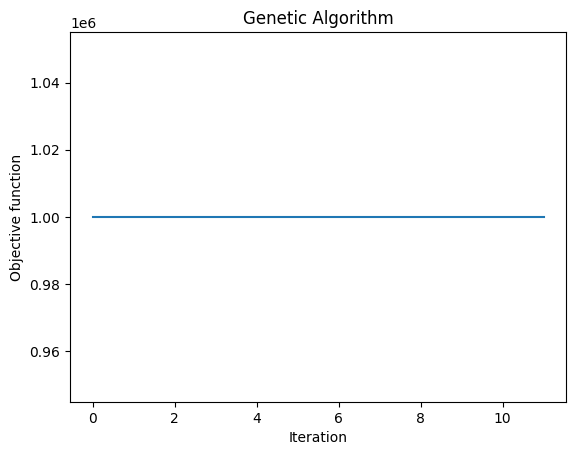

In [31]:
# Run the GA optimization process
model.run()

In [32]:
# Extract the best solution found by the Genetic Algorithm
best_solution = model.output_dict['variable']

# Get feature scores from the first part of the chromosome (feature selection mask)
feature_scores = best_solution[:n_features]

# Select the indices of the top 6 features (highest scores)
top_feature_indices = np.argsort(feature_scores)[-6:]

# Retrieve the names of the selected features
selected_features = [feature_names[i] for i in top_feature_indices]

In [33]:
# Extract best hyperparameters from the GA solution
best_lr = best_solution[n_features]         # Best learning_rate
best_leaves = int(best_solution[n_features + 1])  # Best num_leaves
best_depth = int(best_solution[n_features + 2])   # Best max_depth

# Initialize the final LightGBM model with GA-optimized hyperparameters
final_model = LGBMRegressor(
    learning_rate=best_lr,
    num_leaves=best_leaves,
    max_depth=best_depth,
    random_state=42,
    verbose=-1
)

# Train the final model using only the top 6 selected features
final_model.fit(X_train[selected_features], y_train)

LGBMRegressor(learning_rate=0.07898563631574067, max_depth=8, num_leaves=68,
              random_state=42, verbose=-1)

### Hyperparameter Tunning

In [34]:
# Define the hyperparameter search space for LightGBM
param_space = {
    'num_leaves': (10, 100),          # Controls tree complexity (number of leaves)
    'max_depth': (3, 12),             # Maximum depth of each tree
    'learning_rate': (0.01, 0.3),     # Step size shrinkage to prevent overfitting
    'n_estimators': (50, 300),        # Number of boosting rounds
    'subsample': (0.5, 1.0),          # Fraction of data to be randomly sampled for each tree
    'colsample_bytree': (0.5, 1.0)    # Fraction of features to be randomly sampled for each tree
}


In [35]:
# Function to randomly sample a set of hyperparameters from the search space
def sample_params():
    return {
        'num_leaves': random.randint(*param_space['num_leaves']),                      # Tree complexity
        'max_depth': random.randint(*param_space['max_depth']),                        # Tree depth
        'learning_rate': round(random.uniform(*param_space['learning_rate']), 3),      # Learning rate
        'n_estimators': random.randint(*param_space['n_estimators']),                  # Number of boosting rounds
        'subsample': round(random.uniform(*param_space['subsample']), 2),              # Row subsampling fraction
        'colsample_bytree': round(random.uniform(*param_space['colsample_bytree']), 2) # Feature subsampling fraction
    }


In [36]:
# Function to evaluate the performance (fitness) of a given set of hyperparameters
def evaluate_fitness(params, X, y):
    """
    Perform time series cross-validation and return the average MSE.
    Lower MSE indicates better performance.
    """
    scores = []
    tscv = TimeSeriesSplit(n_splits=5)  # Time series split to preserve chronological order

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, random_state=42, verbose=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(scores)  # Average MSE across all folds

**Genetic Algorithm (GA)-style hyperparameter optimization for LightGBM**

In [37]:
# GA parameters
population_size = 10   # Number of individuals in each generation
generations = 20       # Number of generations to evolve
top_k = 4              # Number of best individuals to retain each generation
mutation_prob = 0.05   # Probability of mutating a parameter

# Step 1: Initialize the population with random hyperparameter sets
population = [sample_params() for _ in range(population_size)]

# Step 2: Evolve over multiple generations
for gen in range(generations):
    print(f"Generation {gen+1}")
    
    # Evaluate each individual's fitness (lower MSE is better)
    fitness_scores = [evaluate_fitness(ind, X, y) for ind in population]
    
    # Sort population by MSE (ascending = best first)
    sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0])]
    
    # Keep only the top_k best individuals
    population = sorted_population[:top_k]
    
    # Generate new individuals via mutation until population size is restored
    while len(population) < population_size:
        parent = random.choice(population)  # Randomly choose a parent from the best individuals
        child = parent.copy()
        
        # Apply mutation with given probability
        if random.random() < mutation_prob:
            param_to_mutate = random.choice(list(param_space.keys()))
            
            # If the parameter is integer-based
            if isinstance(param_space[param_to_mutate][0], int):
                child[param_to_mutate] = random.randint(*param_space[param_to_mutate])
            else:
                # If the parameter is float-based
                child[param_to_mutate] = round(random.uniform(*param_space[param_to_mutate]), 3)
        
        population.append(child)

# Step 3: Best parameters are the first in the sorted population
best_params = population[0]
print("Best hyperparameters found:", best_params)


Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Best hyperparameters found: {'num_leaves': 91, 'max_depth': 4, 'learning_rate': 0.017, 'n_estimators': 120, 'subsample': 0.62, 'colsample_bytree': 0.57}


### Train the final LightGBM model using the best hyperparameters found from GA

In [38]:
# Initialize the model with optimal hyperparameters
final_model = lgb.LGBMRegressor(**best_params)

# Fit the model on the training set using only the selected features
final_model.fit(X_train[selected_features], y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test[selected_features])


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def evaluate_model_performance(df_eval):
    """
    Evaluate model predictions using both statistical and financial metrics.

    Parameters:
    -----------
    df_eval : pd.DataFrame
        DataFrame containing columns:
        - 'Actual': Actual returns
        - 'Predicted': Predicted returns

    Returns:
    --------
    result : dict
        Dictionary containing RMSE, MSE, MAE, MAPE, Sharpe Ratio, Max Drawdown, 
        Total Return, and Directional Accuracy.
    df_eval : pd.DataFrame
        The same DataFrame with added columns for direction and cumulative returns.
    """

    # --- Statistical error metrics ---
    rmse = np.sqrt(mean_squared_error(df_eval['Actual'], df_eval['Predicted']))
    mse = mean_squared_error(df_eval['Actual'], df_eval['Predicted'])
    mae = mean_absolute_error(df_eval['Actual'], df_eval['Predicted'])
    try:
        mape = mean_absolute_percentage_error(df_eval['Actual'], df_eval['Predicted'])
    except:
        mape = np.nan  # Handle division by zero if actual values contain zeros

    # --- Directional Accuracy ---
    df_eval['Direction_Actual'] = np.sign(df_eval['Actual'])
    df_eval['Direction_Predicted'] = np.sign(df_eval['Predicted'])
    directional_accuracy = (df_eval['Direction_Actual'] == df_eval['Direction_Predicted']).mean()

    # --- Cumulative returns ---
    df_eval['Predicted_Cum'] = (1 + df_eval['Predicted']).cumprod()
    df_eval['Actual_Cum'] = (1 + df_eval['Actual']).cumprod()

    # --- Sharpe Ratio ---
    sharpe_ratio = df_eval['Predicted'].mean() / df_eval['Predicted'].std()

    # --- Max Drawdown ---
    rolling_max = df_eval['Predicted_Cum'].cummax()
    drawdown = df_eval['Predicted_Cum'] / rolling_max - 1
    max_drawdown = drawdown.min()

    # --- Total Return ---
    total_return = df_eval['Predicted_Cum'].iloc[-1] - 1

    # Compile results
    result = {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Total Return": total_return,
        "Directional Accuracy": directional_accuracy
    }

    return result, df_eval


In [40]:
# Create evaluation DataFrame
df_eval = pd.DataFrame({
    'Actual': y_test.values,     # Actual returns from the test set
    'Predicted': y_pred          # Predicted returns from the model
}, index=y_test.index)

# Calculate cumulative returns for both actual and predicted values
df_eval['Actual_Cum'] = (1 + df_eval['Actual']).cumprod()
df_eval['Predicted_Cum'] = (1 + df_eval['Predicted']).cumprod()


In [41]:
# Ensure df_eval contains the columns 'Actual' and 'Predicted'
metrics, df_eval = evaluate_model_performance(df_eval)

# Display each performance metric
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value}")


RMSE: 0.04754984745967415
MSE: 0.0022609879934382803
MAE: 0.03578766996086672
MAPE: 10.792864580810438
Sharpe Ratio: -0.42810412685880916
Max Drawdown: -0.40502439332151496
Total Return: -0.3330401994458724
Directional Accuracy: 0.5145631067961165


The evaluation results show that the model achieved relatively low prediction errors, with an RMSE of 0.0475, MAE of 0.0358, and MAPE of 10.79%, indicating that the predicted daily returns are generally close to the actual returns. The MSE value of 0.00226 further confirms low variance in the prediction errors. However, when these predictions are translated into a trading strategy, the financial performance is less promising. The model’s Sharpe ratio is -0.4281, suggesting underperformance compared to a risk-free investment. The maximum drawdown reaches -40.50%, which reflects a substantial peak-to-trough loss, and the total return over the test period is -33.30%, indicating that the strategy would have incurred significant losses. Directional accuracy is 51.46%, only slightly above the 50% expected from random guessing. These results suggest that while the model can fit return values with reasonable accuracy from a statistical standpoint, its predictive power is insufficient to generate profitable trading decisions without further improvements in feature engineering, modeling strategy, or risk management.

In [42]:
# Take the last 100 days of evaluation data
df_eval_100 = df_eval.tail(100).copy()

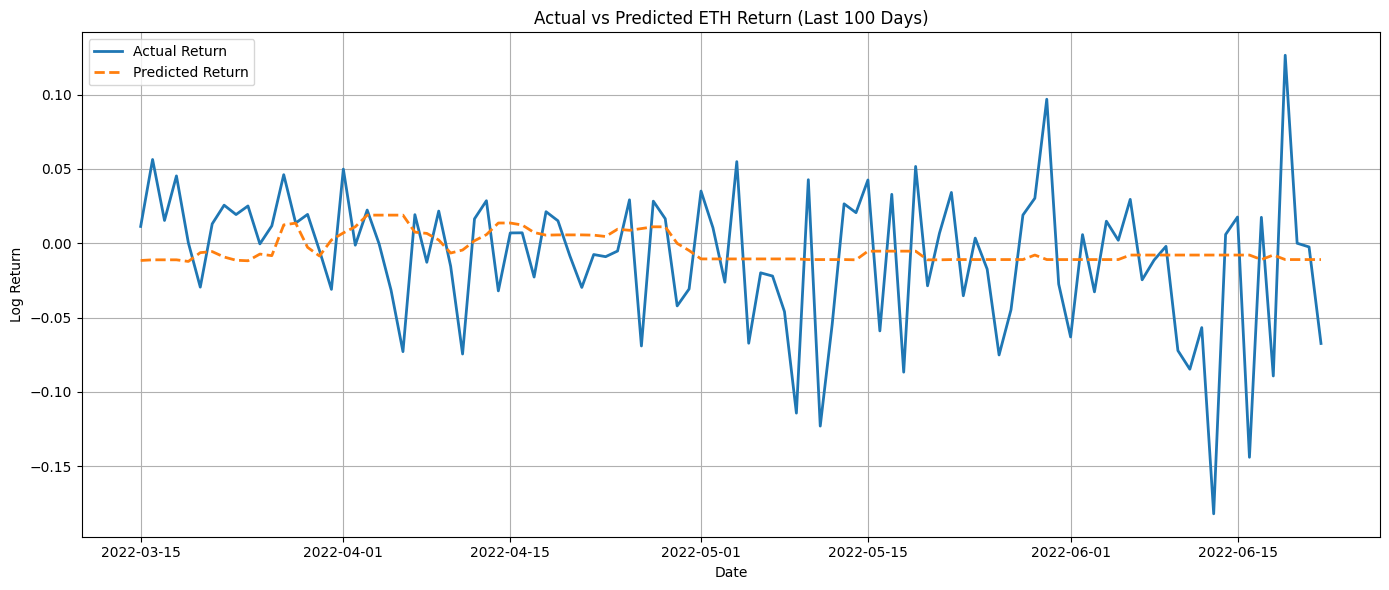

In [43]:
# Plot actual vs predicted ETH returns for the last 100 days
plt.figure(figsize=(14, 6))
plt.plot(df_eval_100.index, df_eval_100['Actual'], label='Actual Return', linewidth=2)
plt.plot(df_eval_100.index, df_eval_100['Predicted'], label='Predicted Return', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted ETH Return (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


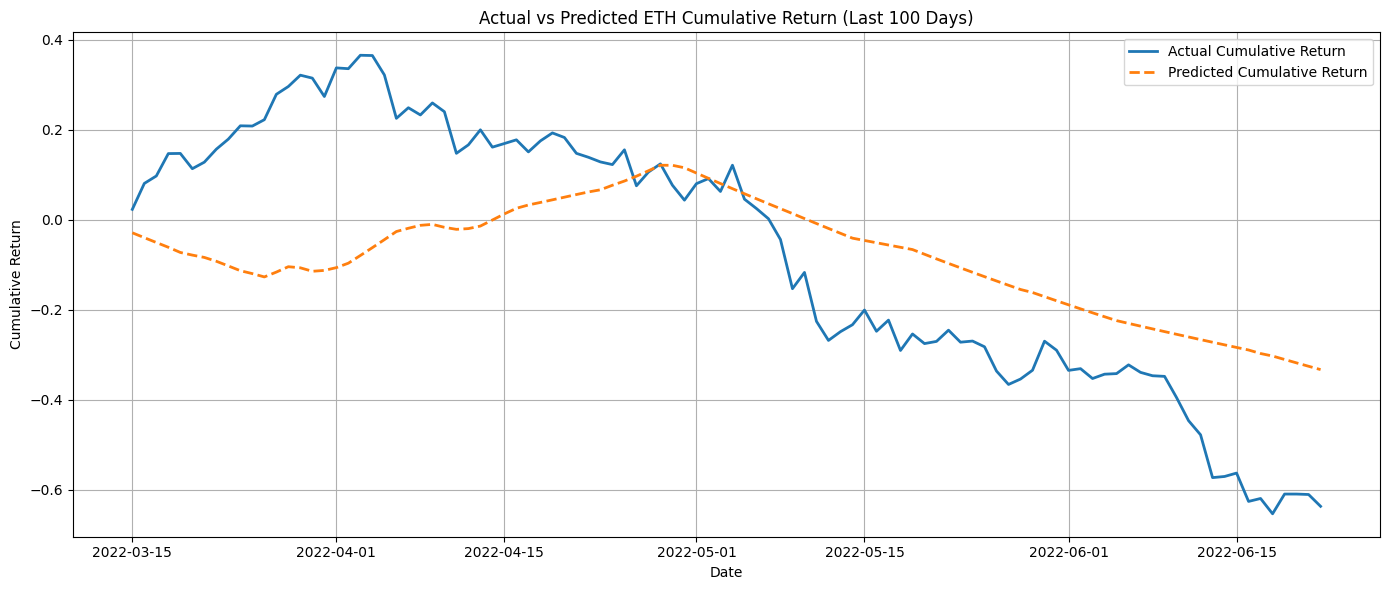

In [44]:
# Plot actual vs predicted cumulative returns for the last 100 days
plt.figure(figsize=(14, 6))
plt.plot(df_eval_100.index, df_eval_100['Actual_Cum'] - 1, 
         label='Actual Cumulative Return', linewidth=2)
plt.plot(df_eval_100.index, df_eval_100['Predicted_Cum'] - 1, 
         label='Predicted Cumulative Return', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted ETH Cumulative Return (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## IV. Conclusion and Recommendations

### Conclusion
The LightGBM model with Genetic Algorithm-based feature selection for predicting Ethereum (ETH) daily returns during the COVID-19 period yielded **mixed results**.  

- **Error metrics**:  
  - RMSE: 0.0475  
  - MAE: 0.0358  
  - MAPE: ~10.79%  
  These indicate that while the model can approximate return magnitudes, its precision for daily movements is limited.  

- **Directional Accuracy**: ~51.45%, only slightly above random guessing.  

- **Financial performance metrics**:  
  - Sharpe Ratio: -0.43 (suboptimal risk-adjusted returns)  
  - Max Drawdown: -40.50% (significant downside risk)  
  - Total Return: -33.3% (underperformance compared to holding ETH).  

The cumulative return plots further illustrate that the model struggled to track actual market trends, especially in volatile periods, often lagging behind real returns.

---

### Recommendations

#### Model Improvements
1. **Expand Feature Set**  
   - Include macroeconomic indicators (interest rates, USD index, commodity prices).  
   - Add blockchain-specific data (transaction volume, active addresses).  

2. **Alternative Models**  
   - Test hybrid models (LightGBM + LSTM) for both short-term patterns and long-term dependencies.  
   - Use ensemble methods combining tree-based and deep learning models.  

3. **Feature Engineering**  
   - Add lagged returns, rolling volatility, and momentum indicators.  
   - Test different rolling window sizes for COVID-19 features.  

4. **Optimization Approach**  
   - Try Bayesian Optimization or Optuna instead of basic GA for tuning.  

---

#### Trading & Practical Use
1. **Directional Focus**  
   - Combine with risk management strategies rather than using as a standalone trading system.  

2. **Risk Management**  
   - Apply stop-loss and take-profit rules to mitigate large drawdowns.  

3. **Market Scope Expansion**  
   - Replicate methodology for other cryptocurrencies to assess generalizability.  

---

## V. Next Steps
1. Apply the same methodology to **Ethereum and Bitcoin in parallel** to compare results.  
2. Explore cross-asset predictive signals (e.g., using BTC indicators to predict ETH returns).  
3. Investigate robustness across different COVID-19 phases and volatility regimes.  
